In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
print("Loading Glove Model")
wordsList = []
wordVectors = []
with open('glove_6B_50d.txt','r',encoding = 'utf8') as ft:
    for line in ft:
        splitLine = line.split()
        wordsList.append(splitLine[0])
        wordVectors.append(np.array([float(val) for val in splitLine[1:]]))
# append none for unknown word
wordsList.append(None)
wordVectors.append([0] * len(wordVectors[0]) ) 
wordVectors = np.array(wordVectors,dtype='f')
print("Done.",len(wordVectors)," words loaded!")

Loading Glove Model
Done. 400001  words loaded!


### Test Tensorflow

In [4]:
maxSeqLength = 10
numDimensions = 50

firstSentence = np.zeros((maxSeqLength), dtype='int32')

firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
print(firstSentence.shape)
print(firstSentence) 


(10,)
[   41   804     0  1005    15  7446     5 13767     0     0]


In [5]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors, firstSentence).eval().shape)

(10, 50)


## Load training Data

In [7]:
print("Loading Training Data")
positiveTwit = []
negativeTwit = []
neutralTwit = []
with open('twitter-2016train-A.txt','r',encoding = 'utf8') as ft:
    for line in ft:
        splitLine = line.split()
        if splitLine[1] == 'positive':
            positiveTwit.append(splitLine[2:])
        elif splitLine[1] == 'negative':
            negativeTwit.append(splitLine[2:])
        else:
            neutralTwit.append(splitLine[2:])
print("Done.",len(positiveTwit)+len(negativeTwit)+len(neutralTwit)," Twits loaded!")

Loading Training Data
Done. 6000  Twits loaded!


In [8]:
len(positiveTwit+negativeTwit+neutralTwit)

6000

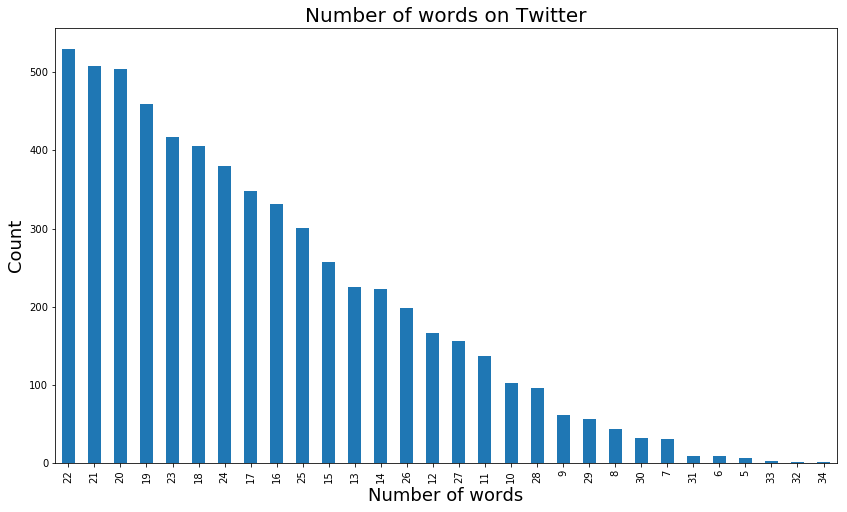

In [9]:
plt.figure(figsize=(14,8))
plt.title('Number of words on Twitter', fontsize=20)
allTwit = pd.DataFrame(positiveTwit+negativeTwit+neutralTwit)
allTwit.count(axis=1).value_counts().plot.bar()
plt.xlabel('Number of words',fontsize=18)
plt.ylabel('Count', fontsize=18)
maxSeqLength = allTwit.count(axis=1).max() 

## Clean data

In [10]:
wanted_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(wanted_chars, "", string.lower())

In [11]:
positiveTwit = []
negativeTwit = []
neutralTwit = []
with open('twitter-2016train-A.txt','r',encoding = 'utf8') as ft:
    for line in ft:
        splitLine = line.split()
        if splitLine[1] == 'positive':
            positiveTwit.append(list(map(cleanSentences,splitLine[2:])))
        elif splitLine[1] == 'negative':
            negativeTwit.append(list(map(cleanSentences,splitLine[2:])))
        else:
            neutralTwit.append(list(map(cleanSentences,splitLine[2:])))
print("Done.",len(positiveTwit)+len(negativeTwit)+len(neutralTwit)," Clean Twits loaded!")

Done. 6000  Clean Twits loaded!


## Convert to ids matrix

In [24]:
#%% convert to word id in wordsList
def to_ids(target, source):
    line_ind = 0
    for line in source:
        word_ind = 0
        for word in line:
            try:
                target[line_ind][word_ind] = wordsList.index(word) + 1
            except ValueError:
                target[line_ind][word_ind] = len(wordsList) - 1
            word_ind = word_ind + 1
        line_ind = line_ind + 1

In [25]:
positive_np = np.zeros((len(positiveTwit), maxSeqLength), dtype='int32')
negative_np = np.zeros((len(negativeTwit), maxSeqLength), dtype='int32')
neutral_np = np.zeros((len(neutralTwit), maxSeqLength), dtype='int32')

to_ids(positive_np, positiveTwit)
to_ids(negative_np, negativeTwit)
to_ids(neutral_np, neutralTwit)
print("ids Matrix Created.", len(positive_np)+len(negative_np)+len(neutral_np)," Twits ids loaded!")

ids Matrix Created. 6000  Twits ids loaded!


## Start training
### Parameter setting

In [15]:
batchSize = 24
lstmUnits = 64
numClasses = 3
iterations = 10000

In [16]:
import tensorflow as tf
tf.reset_default_graph()

# define input data shape
labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

# assign tensor shape and get word vectors
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

In [17]:
#%% set LSTM network
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)


In [18]:
# The output of dynamic RNN is like last hidden state vector.
# Reshape and multiplied by weight matrix and bias term to output final result
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [19]:
#%% define correct prediction and accuracy 
# argmax return max value in tensor align axis=1
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [20]:
#%% define cross entropy loss with a softmax layer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
# use Adam to optimize and learning rate is default 0.01
optimizer = tf.train.AdamOptimizer().minimize(loss)

### Generate random sample

In [21]:
#%%
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 3 == 0): 
            num = randint(1,len(positive_np))
            labels.append([1,0,0])
            arr[i] = positive_np[num-1:num]
        elif (i % 3 == 1):
            num = randint(1,len(neutral_np))
            labels.append([0,1,0])
            arr[i] = neutral_np[num-1:num]
        else:
            num = randint(1,len(negative_np))
            labels.append([0,0,1])
            arr[i] = negative_np[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        pick_lab = randint(1,3)
        if (pick_lab == 1):
            num = randint(1,len(positive_np))
            labels.append([1,0,0])
            arr[i] = positive_np[num-1:num]
        elif(pick_lab == 2):
            num = randint(1,len(neutral_np))
            labels.append([0,1,0])
            arr[i] = neutral_np[num-1:num]
        else:
            num = randint(1,len(negative_np))
            labels.append([0,0,1])
            arr[i] = negative_np[num-1:num]
    return arr, labels


### Create Session

In [22]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [26]:
for i in range(iterations):
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch();
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})

    #Save the network every 10,000 training iterations
    if (i % 1000 == 0 and i != 0):
        save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
        print("saved to %s" % save_path)

saved to models/pretrained_lstm.ckpt-1000
saved to models/pretrained_lstm.ckpt-2000
saved to models/pretrained_lstm.ckpt-3000
saved to models/pretrained_lstm.ckpt-4000


FailedPreconditionError: Failed to rename: models\pretrained_lstm.ckpt-5000.meta.tmp59de7001ecea4e41a611a398c5d71672 to: models\pretrained_lstm.ckpt-5000.meta : The process cannot access the file because it is being used by another process.


## Load trained model

In [27]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
iterations = 10

#saver.restore(sess, tf.train.latest_checkpoint('models'))
saver.restore(sess, 'models/pretrained_lstm.ckpt-3000')

for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (
            sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)
    
saver.restore(sess, 'models/pretrained_lstm.ckpt-6000')
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (
            sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)
    
saver.restore(sess, 'models/pretrained_lstm.ckpt-9000')
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (
            sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-3000
Accuracy for this batch: 83.3333313465
Accuracy for this batch: 66.6666686535
Accuracy for this batch: 66.6666686535
Accuracy for this batch: 75.0
Accuracy for this batch: 54.1666686535
Accuracy for this batch: 70.8333313465
Accuracy for this batch: 66.6666686535
Accuracy for this batch: 62.5
Accuracy for this batch: 75.0
Accuracy for this batch: 75.0
INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-6000
Accuracy for this batch: 91.6666686535
Accuracy for this batch: 87.5
Accuracy for this batch: 91.6666686535
Accuracy for this batch: 83.3333313465
Accuracy for this batch: 91.6666686535
Accuracy for this batch: 91.6666686535
Accuracy for this batch: 83.3333313465
Accuracy for this batch: 83.3333313465
Accuracy for this batch: 87.5
Accuracy for this batch: 95.8333313465
INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-9000
Accuracy for this batch: 91.6666686535
Accuracy f